In [1]:
# ! pip install gensim==3.8.3

In [2]:
import nltk
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
sns.set_context('talk')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jensen116/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jensen116/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jensen116/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/jensen116/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

# Data

In [10]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
class_corpus = get_corpus_df(CORPUS_PATH)


In [13]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 40 to 199
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


# Preprocessing

In [14]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [15]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [16]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [17]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)
    
    return tokenized_text

In [18]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [19]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [20]:
class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [21]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 40 to 199
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
 9   normalized_review         200 non-null    object
 10  tokenized_review          200 non-null    object
 11  lemmatized_tokens         200 non-null    object
 12  lemmatized_text           200 non-null    object
dtypes: int64(1), object(12)
memory usage: 21.9+ KB


# Feature Extraction

## Method 1: TF-IDF

In [22]:
tfidf_vectorizer = TfidfVectorizer()

In [23]:
dtm_class_corpus = tfidf_vectorizer.fit_transform(class_corpus['lemmatized_text'])

In [24]:
features_tfidf_scores = pd.DataFrame(dtm_class_corpus.toarray(), 
                                     columns=tfidf_vectorizer.get_feature_names_out(), 
                                     index=class_corpus.index)

In [25]:
features_tfidf_scores.shape

(200, 13478)

## Method 2: Doc2Vec

In [26]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(class_corpus.lemmatized_tokens)]

In [27]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=200,
                        min_count=1,
                        workers=4)

In [28]:
features_doc2vec = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    features_doc2vec = pd.concat([features_doc2vec, vector])

In [29]:
features_doc2vec.shape

(200, 200)

# Clustering

Before clustering, we need to scale the data to bring parity between all the columns. 

In [30]:
standard_scaler = StandardScaler()

In [31]:
help(StandardScaler)

Help on class StandardScaler in module sklearn.preprocessing._data:

class StandardScaler(sklearn.base._OneToOneFeatureMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  StandardScaler(*, copy=True, with_mean=True, with_std=True)
 |  
 |  Standardize features by removing the mean and scaling to unit variance.
 |  
 |  The standard score of a sample `x` is calculated as:
 |  
 |      z = (x - u) / s
 |  
 |  where `u` is the mean of the training samples or zero if `with_mean=False`,
 |  and `s` is the standard deviation of the training samples or one if
 |  `with_std=False`.
 |  
 |  Centering and scaling happen independently on each feature by computing
 |  the relevant statistics on the samples in the training set. Mean and
 |  standard deviation are then stored to be used on later data using
 |  :meth:`transform`.
 |  
 |  Standardization of a dataset is a common requirement for many
 |  machine learning estimators: they might behave badly if the
 |  individual fea

In [32]:
transformed_features_doc2vec = standard_scaler.fit_transform(features_doc2vec)

In [33]:
model_kmeans = KMeans(n_clusters=4, 
                      random_state=20130810)

In [34]:
model_kmeans.fit(transformed_features_doc2vec)

KMeans(n_clusters=4, random_state=20130810)

In [35]:
labels_kmeans = model_kmeans.labels_

Quality of clustering is determined using the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

In [36]:
silhouette_score(transformed_features_doc2vec, labels_kmeans)

0.49246106

In [37]:
for k in [4, 5, 6, 7, 8, 9]:
    
    model_kmeans = KMeans(n_clusters=k, 
                          random_state=20130810)
    model_kmeans.fit(transformed_features_doc2vec)
    sil_score = silhouette_score(transformed_features_doc2vec, model_kmeans.labels_)
    print(f"k = {k}, silhouette score = {sil_score}")

k = 4, silhouette score = 0.49246105551719666
k = 5, silhouette score = 0.47145989537239075
k = 6, silhouette score = 0.4666896164417267
k = 7, silhouette score = 0.3958945572376251
k = 8, silhouette score = 0.36373645067214966
k = 9, silhouette score = 0.35742247104644775


In [38]:
model_kmeans = KMeans(n_clusters=4)
model_kmeans.fit(transformed_features_doc2vec)
labels_kmeans = model_kmeans.labels_

In [39]:
model_tsne = TSNE(n_components=2)

In [40]:
transformed_values = model_tsne.fit_transform(transformed_features_doc2vec)
X, Y = [], []

for value in transformed_values:
    X.append(value[0])
    Y.append(value[1])

/home/jensen116/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jensen116/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


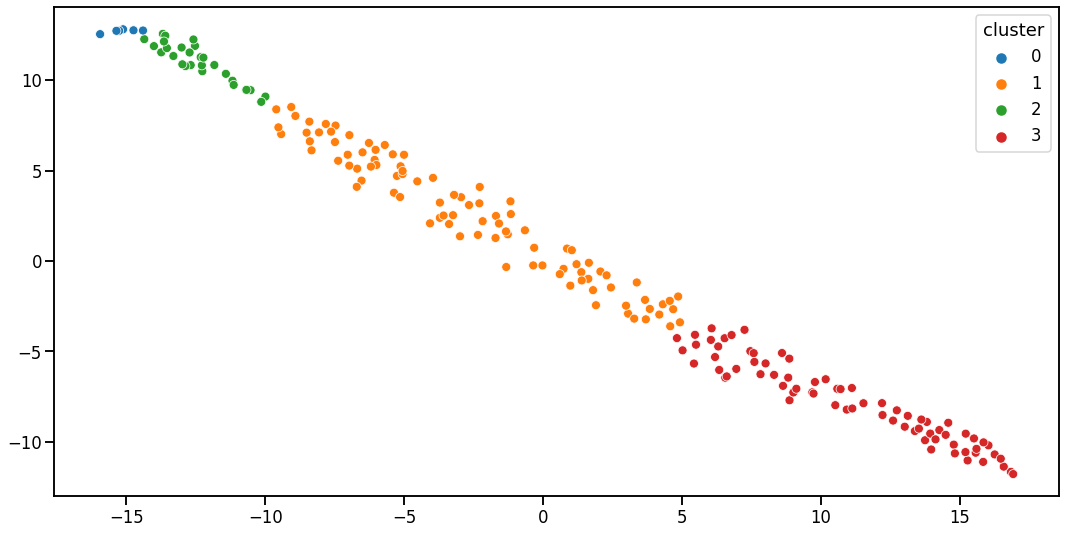

In [41]:
plt.figure(figsize=(18, 9))

labels_kmeans_str = pd.Series(labels_kmeans.astype(str), name='cluster')

sns.scatterplot(x=X, 
                y=Y, 
                hue=labels_kmeans_str,
                hue_order=['0', '1', '2', '3']);

Once the cluster assignment is done, we can then look at the composition of the clusters to qualitatively assess the clusters.

In [42]:
documents_by_cluster = (class_corpus.loc[:, ['DSI_Title', 'Genre of Movie', 'Text']]
                                    .assign(cluster_label=labels_kmeans))

In [43]:
documents_by_cluster.query(f"cluster_label == 1")

,DSI_Title,Genre of Movie,Text,cluster_label
Doc_ID,,,,
40,KCM_Doc1_AngelHasFallen,Action,Boredom sets in long before the start of Angel...,1
41,KCM_Doc2_AngelHasFallen,Action,\nWho ARE all these people?\n\nThat was what...,1
42,KCM_Doc3_AngelHasFallen,Action,Ric Roman Waughs Angel Has Fallen sees U.S. S...,1
43,KCM_Doc4_AngelHasFallen,Action,There is a certain mindless pleasure in the Fa...,1
45,KCM_Doc6_AngelHasFallen,Action,American movie presidents can only make us wis...,1
...,...,...,...,...
191,JSA_Doc2_PitchBlack,Sci-Fi,No other movie opening thrills me more than a ...,1
192,JSA_Doc3_PitchBlack,Sci-Fi,"It's sci-fi season once again, what with this ...",1
197,JSA_Doc8_PitchBlack,Sci-Fi,"Is it an active contempt for the audience, I h...",1


# Conclusion

Quality of features extracted from text (e.g., `tf-idf` and `doc2vec`) can be acertained by the quality of the clusters generated using these features. These clusters also highlight potential patterns within the corpus.
 